# Airbnb NYC Analysis & Dashboard

**Objective:** Analyze Airbnb listings in NYC to extract pricing trends, seasonal insights, and geospatial patterns, and provide actionable recommendations for hosts and investors.

**Tools Used:** Python, pandas, seaborn, matplotlib, plotly, folium, scikit-learn


In [ ]:
#1
!pip install folium plotly geopandas scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from IPython.display import display
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')


In [ ]:
#2
from google.colab import files
uploaded = files.upload()  # Upload AB_NYC_2019.csv here

df = pd.read_csv("AB_NYC_2019.csv")
df.head()


Saving AB_NYC_2019.csv to AB_NYC_2019 (1).csv


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
#3
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [ ]:
#4
# Fill missing reviews_per_month safely
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Remove unrealistic prices
df = df[(df['price'] > 0) & (df['price'] < 1000)]
df = df.reset_index(drop=True)


In [ ]:
#5
# Price per review
df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)

# Active listings
df['active_listing'] = df['number_of_reviews'] > df['number_of_reviews'].median()

# Price vs neighborhood average
neighborhood_avg = df.groupby('neighbourhood')['price'].mean().to_dict()
df['price_vs_neighborhood'] = df['price'] / df['neighbourhood'].map(neighborhood_avg)


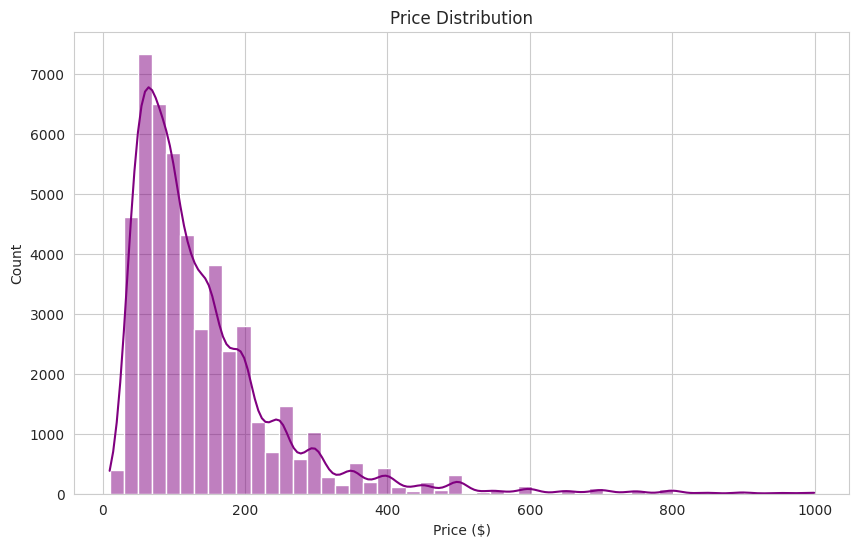

/tmp/ipython-input-1184698468.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='room_type', palette='Set2')


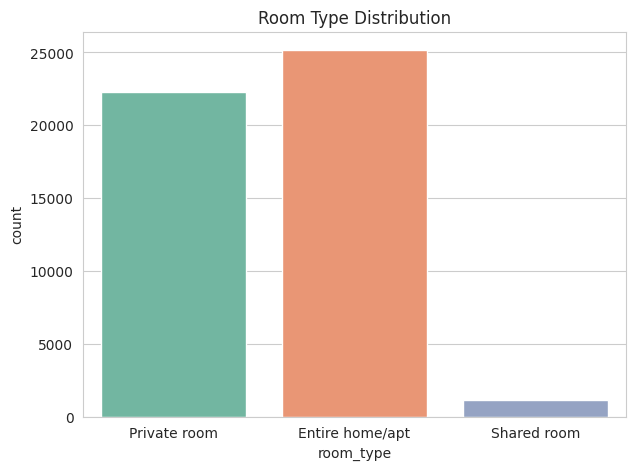

In [ ]:
#6
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True, color='purple')
plt.title('Price Distribution')
plt.xlabel('Price ($)')
plt.show()

plt.figure(figsize=(7,5))
sns.countplot(data=df, x='room_type', palette='Set2')
plt.title('Room Type Distribution')
plt.show()


/tmp/ipython-input-3237420416.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=df, palette='coolwarm')


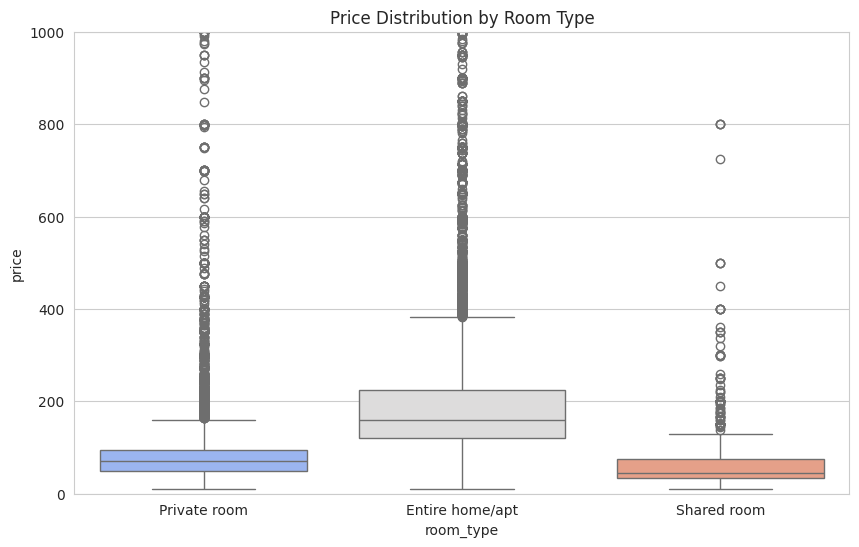

/tmp/ipython-input-3237420416.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='neighbourhood_group', y='price', data=df, palette='Set3')


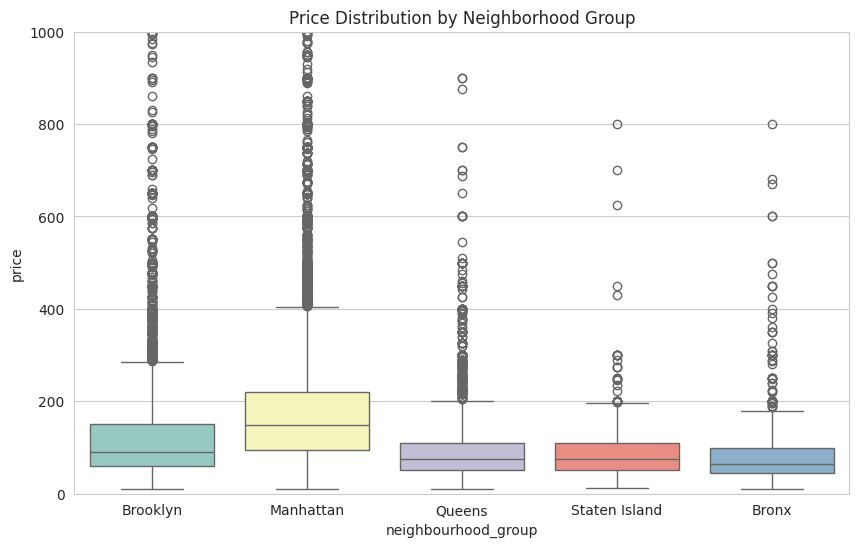

In [ ]:
#7
plt.figure(figsize=(10,6))
sns.boxplot(x='room_type', y='price', data=df, palette='coolwarm')
plt.title('Price Distribution by Room Type')
plt.ylim(0, 1000)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='neighbourhood_group', y='price', data=df, palette='Set3')
plt.title('Price Distribution by Neighborhood Group')
plt.ylim(0, 1000)
plt.show()


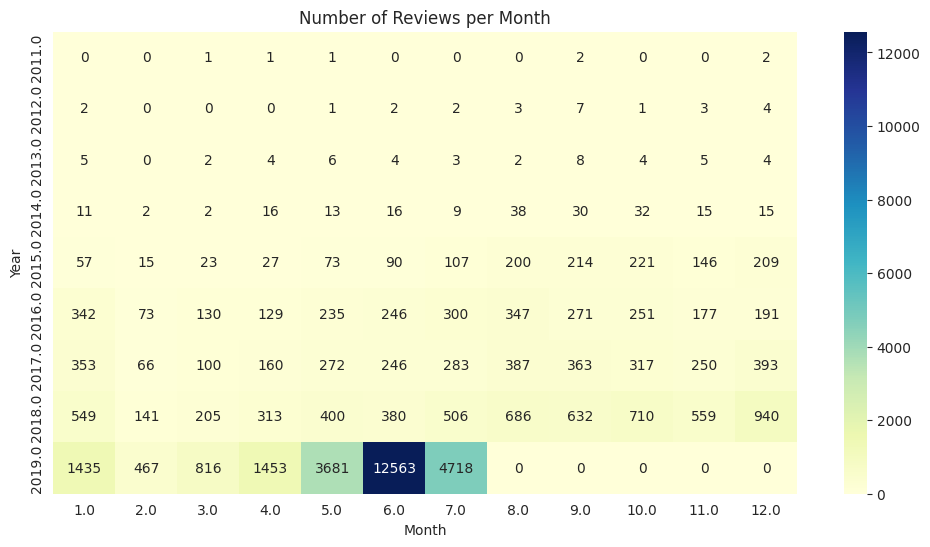

In [ ]:
#8
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['review_month'] = df['last_review'].dt.month
df['review_year'] = df['last_review'].dt.year

monthly_reviews = df.groupby(['review_year','review_month']).size().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(monthly_reviews.fillna(0), cmap='YlGnBu', annot=True, fmt=".0f")
plt.title('Number of Reviews per Month')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()


Mean Squared Error: 9178.72


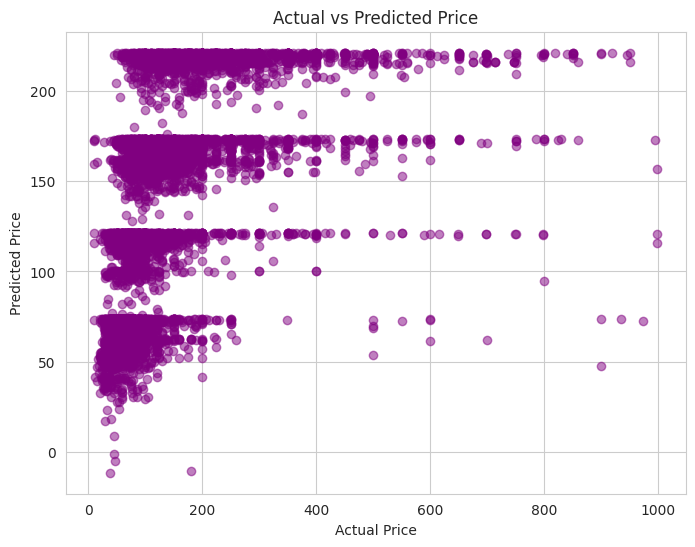

In [ ]:
#9
features = df[['room_type','neighbourhood_group','minimum_nights','number_of_reviews']]
target = df['price']

X = pd.get_dummies(features, drop_first=True)
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


In [ ]:
#11
fig1 = px.scatter(df, x='number_of_reviews', y='price', color='room_type',
                  hover_data=['name','neighbourhood'], title="Price vs Number of Reviews (Room Type)", log_y=True)
fig1.show()

top_neigh = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(10)
fig2 = px.bar(top_neigh, title="Top 10 Most Expensive Neighborhoods",
              labels={'value':'Average Price','neighbourhood':'Neighborhood'}, color=top_neigh.values, color_continuous_scale='Viridis')
fig2.show()


In [ ]:
#12
avg_price = df['price'].mean()
max_price = df['price'].max()
min_price = df['price'].min()
most_common_room = df['room_type'].mode()[0]
most_exp_neigh = df.groupby('neighbourhood')['price'].mean().idxmax()
total_listings = df.shape[0]

# Display KPIs
from IPython.display import HTML
kpi_html = f"""
<div style='display:flex; justify-content: space-between; margin-bottom:20px;'>
    <div style='padding:10px; background:#e0f7fa; border-radius:5px; text-align:center; width:16%'>
        <h4>Average Price</h4><h3>${avg_price:.2f}</h3></div>
    <div style='padding:10px; background:#ffe0b2; border-radius:5px; text-align:center; width:16%'>
        <h4>Maximum Price</h4><h3>${max_price}</h3></div>
    <div style='padding:10px; background:#ffcdd2; border-radius:5px; text-align:center; width:16%'>
        <h4>Minimum Price</h4><h3>${min_price}</h3></div>
    <div style='padding:10px; background:#d1c4e9; border-radius:5px; text-align:center; width:16%'>
        <h4>Most Common Room</h4><h3>{most_common_room}</h3></div>
    <div style='padding:10px; background:#c8e6c9; border-radius:5px; text-align:center; width:16%'>
        <h4>Most Expensive Neighborhood</h4><h3>{most_exp_neigh}</h3></div>
    <div style='padding:10px; background:#f0f4c3; border-radius:5px; text-align:center; width:16%'>
        <h4>Total Listings</h4><h3>{total_listings}</h3></div>
</div>
"""
display(HTML(kpi_html))
